In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


#### Yearly changes

In [2]:
def got_fired_following_season(team):
    team_totals = df[df['Team'] == team]
    for line in open("yearly_changes_by_team2003.csv", "r"):
        if line.split(",")[0] == team:
            years = line.split(",")[1:]
            for year in years:
                year = year.strip()
                df.loc[(df['Team']== team) & (df['Year']== str(int(year) - 2)), 'LeavesNextYr'] = 1
    return df



def tenure(team):
    team_df = df[df['Team'] == team]
    year_min = team_df[team_df['LeavesNextYr'] == 1]
    years = year_min['Year'].tolist()
    if len(years) > 0: #The Bob Stoops exception
        
        years.sort()
        min_year = years[0]
        year = int(min_year)
        counter = 0
        while year <= 2015:
            if int(year) - 1 in map(int, years):
                counter = 1
                df.loc[(df['Year'] == str(year)) & (df['Team'] == team), 'Tenure'] = 0
            else:
                df.loc[(df['Year'] == str(year)) & (df['Team'] == team), 'Tenure'] = counter
                counter += 1
            year += 1
        
    return df


def expectations(team, year):
    team_df = df[df['Team'] == team]
    first_year = int(year) - 6
    total_wins = 0
    total_games = 0
    for season in range(first_year, year):
        wins = team_df.loc[(team_df['Year'] == str(season)), 'Wins']
        games = team_df.loc[(team_df['Year'] == str(season)), 'Games']
        try:
            total_wins += int(wins)
            total_games += int(games)
        except TypeError:
            total_wins += 0
            total_games += 0
    try:
        expectations = float(total_wins)/total_games
    except ZeroDivisionError:
        expectations = 5
    df.loc[(df['Year'] == str(year)) & (df['Team'] == team), 'PreSeasonExpectations'] = expectations
    return df

In [3]:
import glob

columns = ["Team","Wins","Losses","Ties","Games","WinPct", "Year"]

df = pd.DataFrame(columns=columns)


for filename in glob.glob("*records.csv"):
    year = filename.split("_")[0]
    f = DataFrame.from_csv(filename, header = None, index_col=False)
    f['Year'] = year
    f.columns = columns
    dfs = [df, f]
    df = pd.concat(dfs)
df = df.reset_index()
del df['index']


df['LeavesNextYr'] = 0
df['Tenure'] = 0
df['PreSeasonExpectations'] = 0



In [4]:
teams = df['Team'].unique()

for team in teams:
    df = got_fired_following_season(team)
    tenure(team)

In [5]:
seasons = [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
for season in seasons:
    for team in teams:
        expectations(team, season)

In [6]:
df[['Year','Tenure']] = df[['Year','Tenure']].apply(pd.to_numeric)
training_set = df[df['Tenure'] > 0]
training_set = training_set[training_set['Year'] < 2015]
training_set = training_set.reset_index()
del training_set['index']
training_set['ExpVsReality'] = training_set['WinPct'] - training_set['PreSeasonExpectations']
training_set

,Team,Wins,Losses,Ties,Games,WinPct,Year,LeavesNextYr,Tenure,PreSeasonExpectations,ExpVsReality
0,Utah,10.0,2.0,0.0,12.0,0.83333,2003,1,1,0.573529,0.259801
1,Bowling Green,11.0,3.0,0.0,14.0,0.78571,2003,0,1,0.477612,0.308098
2,Louisville,9.0,4.0,0.0,13.0,0.69231,2003,0,1,0.575342,0.116968
3,Oregon State,8.0,5.0,0.0,13.0,0.61538,2003,0,1,0.557143,0.058237
4,Tulsa,8.0,5.0,0.0,13.0,0.61538,2003,0,1,0.220588,0.394792
5,Houston,7.0,6.0,0.0,13.0,0.53846,2003,0,1,0.313433,0.225027
6,Washington,6.0,6.0,0.0,12.0,0.50000,2003,1,1,0.643836,-0.143836
7,UCLA,6.0,7.0,0.0,13.0,0.46154,2003,0,1,0.633803,-0.172263
8,Texas A&M,4.0,8.0,0.0,12.0,0.33333,2003,0,1,0.653333,-0.320003
9,Wyoming,4.0,8.0,0.0,12.0,0.33333,2003,0,1,0.405797,-0.072467


In [7]:
canned = training_set[training_set['LeavesNextYr'] == 1]
canned.shape

(153, 11)

In [8]:
kept = training_set[training_set['LeavesNextYr'] == 0]
training_kept = kept.sample(n=153)

In [9]:
training_kept = training_kept.reset_index()
del training_kept['index']
training_kept

,Team,Wins,Losses,Ties,Games,WinPct,Year,LeavesNextYr,Tenure,PreSeasonExpectations,ExpVsReality
0,Notre Dame,3.0,9.0,0.0,12.0,0.25000,2007,0,3,0.616438,-0.366438
1,San Jose State,5.0,7.0,0.0,12.0,0.41667,2007,0,3,0.366197,0.050473
2,Eastern Michigan,2.0,10.0,0.0,12.0,0.16667,2014,0,1,0.208333,-0.041663
3,Alabama,6.0,6.0,0.0,12.0,0.50000,2004,0,2,0.554054,-0.054054
4,Arizona State,8.0,5.0,0.0,13.0,0.61538,2012,0,1,0.506667,0.108713
5,New Mexico,4.0,9.0,0.0,13.0,0.30769,2012,0,1,0.297297,0.010393
6,Boston College,7.0,6.0,0.0,13.0,0.53846,2013,0,1,0.525641,0.012819
7,Kansas State,8.0,5.0,0.0,13.0,0.61538,2013,0,5,0.586667,0.028713
8,Georgia Tech,7.0,7.0,0.0,14.0,0.50000,2012,0,5,0.625000,-0.125000
9,Central Michigan,8.0,6.0,0.0,14.0,0.57143,2007,0,1,0.422535,0.148895


In [10]:
training_data = pd.concat([training_kept, canned])
training_data = training_data.reset_index()
del training_data['index']
training_data

,Team,Wins,Losses,Ties,Games,WinPct,Year,LeavesNextYr,Tenure,PreSeasonExpectations,ExpVsReality
0,Notre Dame,3.0,9.0,0.0,12.0,0.25000,2007,0,3,0.616438,-0.366438
1,San Jose State,5.0,7.0,0.0,12.0,0.41667,2007,0,3,0.366197,0.050473
2,Eastern Michigan,2.0,10.0,0.0,12.0,0.16667,2014,0,1,0.208333,-0.041663
3,Alabama,6.0,6.0,0.0,12.0,0.50000,2004,0,2,0.554054,-0.054054
4,Arizona State,8.0,5.0,0.0,13.0,0.61538,2012,0,1,0.506667,0.108713
5,New Mexico,4.0,9.0,0.0,13.0,0.30769,2012,0,1,0.297297,0.010393
6,Boston College,7.0,6.0,0.0,13.0,0.53846,2013,0,1,0.525641,0.012819
7,Kansas State,8.0,5.0,0.0,13.0,0.61538,2013,0,5,0.586667,0.028713
8,Georgia Tech,7.0,7.0,0.0,14.0,0.50000,2012,0,5,0.625000,-0.125000
9,Central Michigan,8.0,6.0,0.0,14.0,0.57143,2007,0,1,0.422535,0.148895


In [11]:
features = training_data[["Tenure", "ExpVsReality"]]
#features = training_data[["ExpVsReality"]]
outcome = training_data["LeavesNextYr"]


In [12]:
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier

In [13]:
X_scaled = preprocessing.scale(features)
X_scaled.shape
outcome.shape

(306,)

In [14]:
logreg2 = LogisticRegression()
scores=cross_val_score(logreg2, X_scaled, outcome, cv=10, scoring='accuracy')
print scores
print scores.mean()

[ 0.46875     0.65625     0.5625      0.63333333  0.73333333  0.56666667
  0.6         0.4         0.6         0.7       ]
0.592083333333


In [15]:
rf_model2 = RandomForestClassifier()
scores=cross_val_score(rf_model2, X_scaled, outcome, cv=10, scoring='accuracy')
print scores
print scores.mean()

[ 0.5625      0.78125     0.53125     0.53333333  0.63333333  0.4         0.5
  0.43333333  0.6         0.63333333]
0.560833333333


In [16]:
svm_model2=svm.SVC()
scores=cross_val_score(svm_model2, X_scaled, outcome, cv=10, scoring='accuracy')
print scores
print scores.mean()

[ 0.59375     0.75        0.71875     0.63333333  0.7         0.56666667
  0.56666667  0.5         0.56666667  0.76666667]
0.63625


In [17]:
k_range=range(1,51)
k_scores1=[]
for k in k_range:
    knn1 = KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn1, X_scaled, outcome, cv=10, scoring='accuracy')
    k_scores1.append(scores.mean())
print k_scores1
avg_kscore = sum(k_scores1)/len(k_scores1)

[0.5904166666666667, 0.56812499999999999, 0.52562500000000001, 0.53520833333333329, 0.56104166666666655, 0.53187499999999999, 0.54541666666666666, 0.56479166666666658, 0.55145833333333338, 0.58124999999999993, 0.55437500000000006, 0.59291666666666665, 0.56083333333333329, 0.58687499999999992, 0.58083333333333331, 0.59999999999999987, 0.59958333333333325, 0.60312500000000002, 0.60645833333333332, 0.6127083333333333, 0.6256250000000001, 0.61270833333333319, 0.60937500000000011, 0.61937500000000001, 0.61916666666666675, 0.62562499999999999, 0.59354166666666663, 0.61020833333333335, 0.61020833333333324, 0.60729166666666667, 0.60395833333333337, 0.6010416666666667, 0.5970833333333333, 0.59749999999999992, 0.59770833333333329, 0.59729166666666678, 0.5970833333333333, 0.59416666666666673, 0.59416666666666662, 0.59729166666666678, 0.59083333333333332, 0.59395833333333337, 0.58770833333333328, 0.60666666666666669, 0.59999999999999998, 0.5904166666666667, 0.59020833333333333, 0.60020833333333334

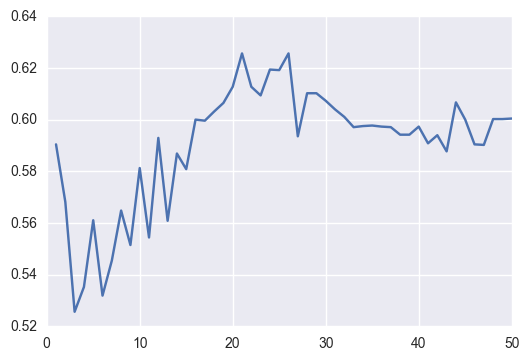

In [18]:
plt.plot(k_range, k_scores1)
plt.show()

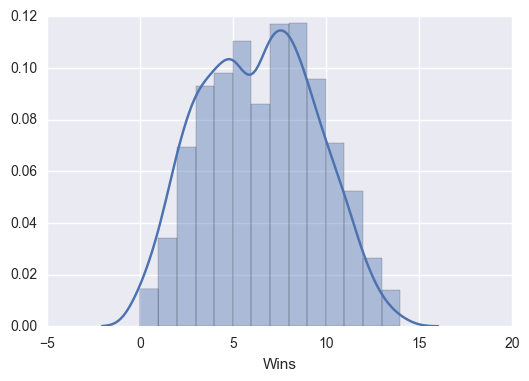

In [19]:
sns.distplot(df['Wins'], bins = 14)

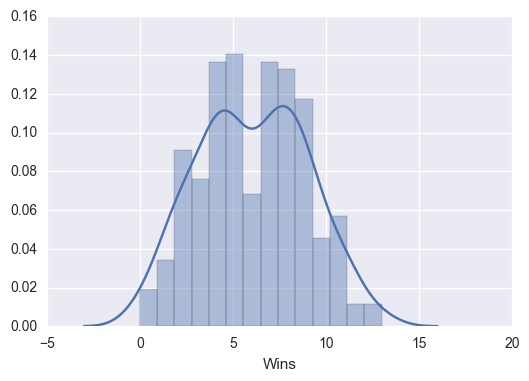

In [20]:
canned = df[df['LeavesNextYr'] == 1]
sns.distplot(canned['Wins'], bins = 14)

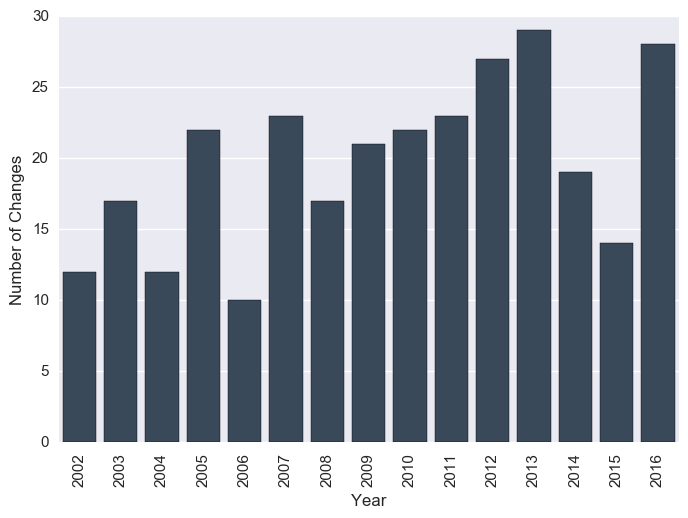

In [21]:
changes = pd.read_csv("~/Documents/310analytics/github/hot_seat_2016/yearly_turnover.csv")
df = pd.DataFrame(changes)

sns.set_context("notebook", font_scale=1.1)

yearly_plot=sns.barplot(x='Year', y='Number of Changes', data=df, color="#34495e")

yearly_plot.set_ylabel("Number of Changes")

for item in yearly_plot.get_xticklabels():
    item.set_rotation(90)
plt.show()